In [8]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

- [HuggingFace Deep RL course](https://huggingface.co/deep-rl-course/unit0/introduction?fw=pt)
- [HuggingFace Deep RL course github](https://github.com/huggingface/deep-rl-class)
- [Reinforcement Learning book: Sutton](http://incompleteideas.net/book/RLbook2020.pdf)


# Reinforcement Learning

We have previously consider two branches of Machine Learning
- Supervised Learning
- Unsupervised Learning

There is a third branch called *Reinforcement Learning*.

Reinforcement Learning is the process whereby an *agent* 
- learns to perform a task involving a *sequence* of decisions.
- through the *experience* gained by making decisions

An analogy: think about how someone learns to play a game of cards
- No initial knowledge (other than rules of the game)
- Plays multiple games
    - After each move: player receives a measure of the quality of the move
    - Player updates the policy for making moves based on this feedback

The world in which the agent operates is called the *environment*.

This world contains a set of relevant features of the world (called the *state*) and the laws/rules that govern behavior in this world.
- rules of a game
- laws of physics

The agent may only have a partial view (an *observation*) of the state
- the agent's own hand, but not its opponent's hand, in a game of cards

At each step: the agent must make a decision (choose an *action*) based on the observation, resulting in
- an updated environment (and resulting observations)
- the agent receiving a *reward*

The goal is for the agent to maximize the rewards received over the lifetime of decisions
(the *episode* or *trajectory*)

The *policy* is the function that guides the actions decisions.

An *episode* (or *trajectory*) is a sequence that records the events as agent
follows its policy in making decisions.

Here is a timeline of an episode
- column labeled "Agent": actions chosen by the Agent
- column labeled "Environment": the responses generated in reaction to the decision

Step  &nbsp; &nbsp;| Agent | Environment | Notes
:---|:---|:---|:---
0 | | $\stateseq_0$    | Environment chooses initial state
  | $\pi(\stateseq_0)$ | $\rewseq_1, \stateseq_1$
1 | $\pi(\stateseq_1)$ | $\rewseq_2, \stateseq_2$
$\vdots$
$\tt$ | $\pi(\stateseq_\tt)$ | $\rewseq_{\tt+1}, \stateseq_{\tt+1}$| Agent follows policy to choose action $\pi(\stateseq_\tt)$
  | | | Environment responds to action by giving reward $\rewseq_{\tt+1}$ and changing state to $\stateseq_{\tt+1}$
$\vdots$


Consider how an agent might learn to play a two-player game of cards called "21"
- The *state*
    - agent's cards
    - opponent's cards
    - cards in the deck
- An *observation*
    - the agent's cards
    - the *number* of cards remaining in the deck
- The *actions* of the agent
    - ask for an additional card
    - hold
- The environment updates as a result of the agent's action
    - The player's hand is updated
    - The opponent makes its own decision, updating it's hand
    - The decks is updated (if the agent receives a card)
    - The agent receives a reward
        - in some games, the only rewards are received at the game's end
- The game continues
    - until a terminal state is reached: both players do not/can not make additional decisions

On a superficial level we can try treating this as a case of Supervised Learning
similar to the "predict the next" (Language model) task.
- the episode is encoded as a sequence of tuples
    - state, action, reward, next state
- the agent tries to extend the sequence to produce the next action
    - the environment then extends the sequence with the reward and next state
    
*Offline RL* can be cast as a Superivised Learning task on sequences.

The fundamental departure from Supervised Learning
- the *agent's action* at step $\tt$ affects the future values of the sequence
- the *agent's policy* after step $\tt$ is changed by the feedback (reward of action)

Formally, we have described a *Partially Observable Markov Decision Process (POMDP)*

If the state is *completely observable* to the agent (*observation = *state*) then this is called simply a
*Markov Decision Process (POMDP)*

For easy of presentation: we will assume *observation = state*

Here is some [code](external/handson-ml2/18_reinforcement_learning.ipynb#A-simple-hard-coded-policy) from Geron's book
- the game: agent tries to balance a pole
- actions: move base (black box at bottom) right/move left
- reward: if move in direction that keeps pole upright


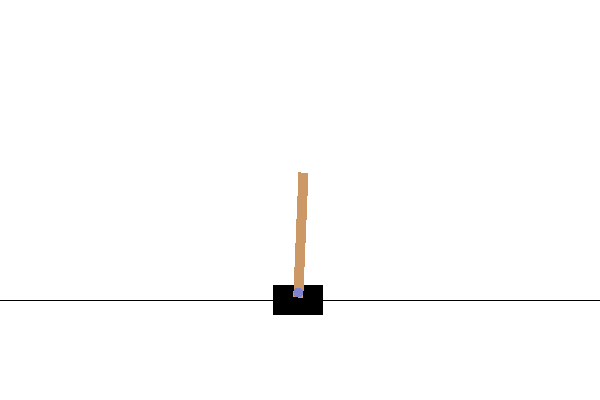

In [2]:
from IPython.display import Image
Image(open('images/cart_pole.gif','rb').read())

Code
- each episode has 200 moves
- the game is played for 500 episodes
- the *observation* is 
    - direction base is moving (right == 1)
    - the angle of the pole (positive: leaning right)
    - angular velocity of the pole (positive: tilting right)
- action $\in {0,1}$: move left/move right
- policy: move left if angle is negative; move right otherwise

# Challenges

- On-line versus off-line training
    - On-line training data: training examples obtained through *experience*: play the game
    - Your initially un-trained, poor action choices affect the examples you learn from
- Sparse rewards
    - If rewards are only received at game's end:
        - how do you attribute the end reward with the action choice at each move ?
    - how do you rank the possible action choices at each move without immediate reward feedback ?
- The optimal reward may not be knowable (no *right* answer)
    - what is the *best* move in a game of chess ?
        - may be conditional on the quality of your opponent
        - may not be an ominiscient opponent to learn from
    - can possibly find better answers through *exploration* of previously untested actions
        - rather than *exploitation* of the best previously-tried action
    - [Sutton: Evaluative vs Instructive feedback](ncompleteideas.net/book/RLbook2020.pdf#page=4)
        - you are not *instructed* with the best action
        - you are given an evaluation of your action through feedback

# Deep Reinforcement Learning

*Deep Reinforcement Learning* refers to the special case of Reinforcement Learning where
- the *policy* is a parameterized (by $\theta$) function mapping  states $\stateseq$ to  (a probability distribution) actions
    $$
    \pi_\theta( \actseq | \stateseq )
    $$
- implemented as a Neural Network
   
Our initial presentation will be of fixed (non-parameterized) policies.
- We will subsequently introduce parameterized Neural Networks to implement the functions we define

# Notation

Term | Definition
:---|:---
$\States$   | **Set** of possible states
$\Actions$  | **Set** of possible actions
$\Rewards$   | **function** $\States \times \Actions \to \Reals$
             | maps state and action to a reward
$\disc$      | discount factor for reward one step in future
 |
$\stateseq_\tt$  | The state at beginning of time step $\tt$
$\actseq_\tt$    | The action performed at time step $\tt$
$\rewseq_\tt$    | The reward resulting form the action performed at time step $\tt$   
 |
$\transp$     | **Function** $\States \times \Actions \to \States \times \Rewards$
              | Transition probability: maps state and chosen action 
              | to new state and reward received


\begin{array}[lll]\\
\stateseq_0, \actseq_0, \rewseq_1, \ldots \stateseq_\tt, \actseq_\tt, \rewseq_{\tt+1}, \ldots
 & \textbf{sequence}: \text{Episode/Trajectory} \\
& \text{sequence of states, action performed, reward received} \\
\transp({ \state', \rew | \state, \act }) & \textbf{Transition probability} \text{ (rules of the game)} \\
& = \transp({\stateseq_\tt = \state', \rewseq_\tt = \rew | \stateseq_{\tt-1} = \state, \actseq_{\tt-1} = \act }) \\
 & \textbf{Markov Decision Process} \text{: depends only on }  \stateseq_{\tt-1} \\
 & \text{and not on history } \stateseq_0, \ldots, \stateseq_{\tt-1} \\
\pi(\act | \state) & \textbf{probability} \text{ Policy (decision process for agent)} \\
                   & \pi(\actseq_\tt | \stateseq_\tt) = (\rewseq_{\tt+1}, \stateseq_{\tt+1}) \\
                   & \text{action } \actseq_\tt \text{ occurs in state } \stateseq_\tt \\
                   & \text{resulting in reward } \rewseq_{\tt+1} \text{ and transition to state } \stateseq_{\tt+1} \\
\end{array}

**Notes on episodes**

- The triple of elements corresponding to experience number $\tt$
    - is $\stateseq_\tt, \actseq_\tt, \rewseq_{\tt+1}$ 
    - **not** $\stateseq_\tt, \actseq_\tt, \rewseq_\tt$
    - **not** $\rewseq_\tt, \stateseq_\tt, \actseq_\tt$
        - i.e., there is a reward (without action) from being in the initial state
        - some presentations use this; we will adopt the notational standard of the [Sutton and Barto book](http://incompleteideas.net/book/RLbook2020.pdf).
- The Algorithms evaluating experience number $\tt$
    - **do not have access** to future experiences numbered $\tt' > \tt+1$
    - they gain access to the next experience $\tt+1$
        - by "playing the game"
        - submitting $\actseq_\tt$ to the environment and receiving $\rewseq_{\tt+1}$ and $\stateseq_{\tt+1}$
    - Under the assumption of MDP (Markov Decision Process)
        - the algorithm *does not need* access to experiences numbered $\tt' < \tt$
- Episodes are more a notation/record than a piece of data used by an algorithm 

# Solving an RL system

A policy $\pi$ is a function mapping a state to an action.

It is the "algorithm" that guides the actions behavior.

The "solution" to an RL system is the optimal policy $\pi^*$ that maximizes *return* from the initial state
- return is sum of discounted rewards accumulated by following the policy from a given state
$$
\begin{array} \\
G_\tt & = & \sum_{k=0}^\tt {  \gamma^k * \rewseq_{\tt+k+1} } \\
      & = & \rew_{\tt+1}  + \gamma * G_{\tt+1} \\
\end{array}
$$
where $\gamma$ is a factor for discounting future returns.


One approach to finding the optimal policy is to
- learn a "model" of the environment (state and transition probabilities)
- derive optimal actions (given a state) through knowledge (via the model) of how the environment will respond

This solution method is called *model-based*.

We will focus on *model-free* methods


How do we find the optimal policy $\pi$ ?



The way we find the optimal policy is typically via an iterative process
- We construct a sequence of improving policies 
$$
\pi_0, \ldots, \pi_p, \ldots
$$
that hopefully converges to $\pi^*$.



There are two main directions for constructing the policy
- Value-based
- Policy-based

# Value-based methods: concepts

Suppose we could assign a *value* to each state
- the sum of rewards over the episode starting with this state
- this is called the *return*

We could define a policy based on these state values
- choose the action that leads to the state with highest value ("greedy" policy)

This is the basis of valued-based methods.

A valued-based method assigns a value to each state
- constructs a function $\statevalfun_{\pi}: \States \to \Reals$
- the process of assigning values to states will also be iterative
- We will build a sequence of hopefully more accurate approximations of $\statevalfun_\pi$
$$
\statevalfun_{\pi,0} \ldots \statevalfun_{\pi,k} \ldots
$$
    

For simplification, let us assume for the moment that
- the sets of states, actions and rewards be *finite*.



##  Evaluating a policy: State-Value function:

We can formalize the value of a policy with the help of a little notation.

The *state-value function* for policy $\pi$ is a map from states to (discounted) future rewards
- let $G_\tt$ denote the *return*  discounted future rewards from state number $\tt$ in the episode sequence
$$
G_\tt = \sum_{k=0}^\tt {  \gamma^k * \rewseq_{\tt+k+1} } 
$$

$$
\statevalfun_\pi(\state): \States \to \Reals
$$

\begin{array} \\
\statevalfun_\pi(\state) & = & \E_\pi ( G_\tt  | \stateseq_\tt =  \state ) \\
& = & \E_\pi  \left( \sum_{k=0}^\infty {  \disc^k \rewseq_{t+k+1} | \stateseq_\tt = \state }  \right) \\
\end{array}

One can express the state-value function in recursive form
- the *Bellman equation* for the state-value function

\begin{array} \\
\statevalfun_\pi(\state) & = & \E_\pi ( G_\tt  | \stateseq_\tt =  \state ) \\
& = & \E_\pi  \left( \rewseq_{\tt+1} + \disc G_{\tt+1} | \stateseq_\tt =  \state  \right) & \text{immediate reward } \rewseq_{\tt+1} \\
    & & & \text{ plus discounted future rewards } G_{\tt+1} \\
& = & \E_\pi  \left( \rewseq_{\tt+1} + \disc \statevalfun_\pi ( \stateseq_{\tt+1})  | \stateseq_\tt =  \state  \right) & \text{since } \statevalfun_\pi ( \stateseq_{\tt+1}) = \E_\pi \left( G_{\tt+1} | \stateseq_\tt =  \state \right) \\
\end{array}



Notice the recursive relationship between the action-value function of current state 
$\statevalfun_\pi (\state)$
and the successor state
$\statevalfun_\pi (\state')$

This formulation leads to the recursive Dynamic Programming solution.

If we had perfect knowledge of the environment ($\transp$ in particular) we could mathematically evaluate
$\statevalfun_\pi(\state)$.

Continuing the derivation (by evaluating the Expectation):

\begin{array} \\
& = & \sum_{\act}  \pi(\act, \state) \sum_{\state'} \sum_{\rew} \transp(\state', \rew | \state. \act)  
    \left( \rew + \disc \E_\pi ( G_{\tt+1} | \stateseq_{\tt+1} = \state') \right) & \text{expectation over all possible actions } \act \text{ from state } \state \\
    & & & \text{of immediate reward } \rew \\
    & & & \text{and discounted future reward} \\
    & & & \text{resulting from successor state } \state' \text{ of action } \act \\
& = &  \sum_{\act}  \pi(\act, \state)  \sum_{\state', \rew} \transp(\state', \rew | \state. \act)  
    \left( \rew + \disc \statevalfun_\pi(\state') \right)
\end{array}

Of course, we can't evaluate the equation without knowing the Transition Probability
function $\transp$ so this is just theoretical.

What we need to do in practice is  to create an *approximation* of $\statevalfun_\pi$.
- by gaining experience from playing episodes

Learning from experience is one of the key aspects of Reinforcement Learning.

## Evaluating a policy: Action-Value function

The state-value function associates the return (discounted future rewards) with a state, without reference to an action.

We can get more fine-grained with an *action-value function* that maps 
(state, action) pairs to (discounted) future rewards.

$$
\actvalfun_\pi: \state \times \act \to \Reals
$$

\begin{array} \\
\actvalfun_\pi(\state, \act) & = & \E_\pi ( G_\tt  | \stateseq_\tt = \state, \actseq_\tt = a ) \\
& = & \E_\pi \left( \rewseq_{\tt+1} + \disc \max{a'} \actvalfun_\pi(\state_{\tt+1}, a') \right) & \text{immediate reward } \rewseq_{\tt+1} \\
& & & \text{plus discounted future reward earned by} \\
& & & \text{choosing best action } \act' \text{ in new state } \state_{\tt+1} \\
& = & \E_\pi  \left( \sum_{k=0}^\infty {  \disc^k \rewseq_{t+k+1} | \stateseq_\tt = \state, \actseq_\tt = \act }  \right) \\
\end{array}

This helps us to discover the optimal action given a state
- Find the action $\act$
- that maximizes the value of future rewards

$$
\pi^*(\state) = \argmax{\act} \actvalfun(\state, \act)
$$

## Iterative approximation of $\statevalfun_\pi$

Reinforcement Learning algorithms usually seek to *approximate* the value of a strategy
- through an iterative process
- based on experience (episodes)

We will build a sequence of hopefully more accurate approximations of $\statevalfun_\pi$
$$
\statevalfun_{\pi,0} \ldots \statevalfun_{\pi,k} \ldots
$$
beginning with an uninformed initial approximation $\statevalfun_{\pi,0}$

Approximation $\statevalfun_{\pi,k+1}$ improves on $\statevalfun_{\pi,k}$
through the experience gained in one (or more) episodes.

## Iterative improvement of policy

The optimal policy $\pi^*$ is the one with greatest $\statevalfun_\pi$ for all states $\state \in \States$
$$
\pi^* = \argmax{\pi} \statevalfun_\pi (\state)
$$

We often find $\pi^*$ by an iterative process.

That is, we create a sequence of improving policies
$$
\pi_0, \ldots, \pi_p, \ldots
$$
which hopefully converges to $\pi^*$.

Once we have an approximation of $\statevalfun_\pi$ for the current policy $\pi_p$
- we can derive an improved policy $\pi_{p+1}$
- by a policy update:
    - for each $\state \in \States$
    \begin{array} \\
    \pi'(\state) & = & \argmax{\act} \sum_{\state', \rew} {   \transp(\state', \rew | \state, \act) ( \rew + \disc \statevalfun_\pi( \state' ) )  } & \text{chose value maximizing action } \act \\
    & = & \argmax{a} \statevalfun_\pi (\state) & \\
    \end{array}

    - if $\pi' \ne \pi$, replace $\statevalfun_\pi$ with $\statevalfun_{\pi'}$

We can perform repeated policy updates until $\pi_{p+1} = \pi_p$
- note that the policy produced is *deterministic* (because of the $\argmax{}$)

## Updating slowly: Monte-Carlo and Temporal Difference

Improvement of both State-value function or Action-value functions is iterative.

One might imagine that, once we have a better approximation, we should use it immediately.

In fact, we will typically phase in improvements using a *learning rate* $\alpha$ 
- similar
to how we use a learning rate in conjunction with gradients in Gradient Descent.

    new value = old value + alpha * ( new value - old value )
    

The reasons for this are
- the update is *locally correct* (e.g., for state $\stateseq$)
- but perhaps not *globally* correct
    - a transition *from* a source state $\state'$ leading to updated target state $\state$ may no longer be optimal for the source state $\state'$

Let's illustrate with updates to $\statevalfun_\pi$ and $\actvalfun_\pi$.

By playing a single episode we can calculate $G_\tt$ for each step $\tt$ in the episode.

$G_\tt$ affects $\statevalfun_\pi$ for state $\state$ through the above equations

\begin{array} \\
\statevalfun_\pi(\state) & = & \E_\pi ( G_\tt  | \stateseq_\tt =  \state ) \\
& = & \E_\pi  \left( \rewseq_{\tt+1} + \disc G_{\tt+1} | \stateseq_\tt =  \state  \right) & \text{immediate reward } \rewseq_{\tt+1} \\
    & & & \text{ plus discounted future rewards } G_{\tt+1} \\
\end{array}

Since $\statevalfun_\pi(\state_\tt) = G_\tt$, we might be tempted to update
\begin{array} \\
\statevalfun_{\pi, k+1} (\state_\tt) & = & G_\tt
\end{array}

Instead, we use a *learning rate* $\alpha$, just like Gradient Descent, to slowly introduce
the updated value.

\begin{array} \\
\statevalfun_{\pi, k+1} (\state_\tt) & = & \statevalfun_{\pi, k} (\state_\tt) + \alpha * \left( G_\tt  -\statevalfun_{\pi, k} (\state_\tt)\right) & \text{Update by a fraction of the change }\\
\end{array}

This update is called the *Monte Carlo* method.

There is an alternative to the Monte Carlo approach.

Rather than using $G_\tt$ (sum of rewards from a state) for updating, we use the *immediate* reward $\rewseq_\tt$.

\begin{array} \\
\statevalfun_{\pi, k+1} (\state_\tt) & =  & \statevalfun_{\pi, k} (\state_\tt) + \alpha * \left( \rewseq_{\tt +1} + \gamma \statevalfun_{\pi, k+1}(\stateseq_{\tt+1}) -  \statevalfun_{\pi, k} (\state_\tt)\right) &  \text{since } G_\tt = \rewseq_{\tt +1} + \gamma \statevalfun_{\pi, k+1}(\stateseq_{\tt+1}) \\
    & & &\text{immediate reward } \rewseq_{\tt+1} \\
    & & & \text{ plus discounted future rewards } G_{\tt+1} \\ \\
& & &\text{Update by a fraction of the change }\\
\end{array}

This is called the *Temporal Difference (TD)* method
- can be applied at *each step* of the episode
- rather than at the *end* of the episode as in Monte Carolo

## Greed is not always good: $\epsilon$-Greedy Policy

The way we hope to learn the optimal (or at least, a good) policy is through experience
- many episodes

This may tempt us to *always* choose the "best" action (known from experience thus far) in a given state.

Greed is not the friend of learning

Recall: We initialize $\statevalfun_\pi$ and $\actvalfun_\pi$ with uninformed choices.
- the initial "best" action $\act$ for state $\state$ is uninformed

If we always choose the same action $\act$ when visiting state $\state$
- We may never getter better information on the return of an adjacent state $\state'$ reachable by action $\act'$
- The alternate action $\act'$ be have higher return

A *greedy policy* is one that always chooses the action with highest return
- as estimated by our past experience

An *$\epsilon$-greedy policy* is a combination of a greedy policy and random action
- chooses the action of the greedy policy with probability $(1 - \epsilon)$
- chooses a random action with probability $\epsilon$.

An $\epsilon$-greedy policy tries to balance
- *exploitation*: choose the best action (as know from past experience)
- *exploration*: gaining a better mapping of the environment by choosing alternative actions

# Value-based algorithms to find $\pi^*$

## Value-based algorithm 1: Policy iteration

*Policy iteration* is an algorithm that improves $\pi_p$ to $\pi_{p+1}$ by alternating two steps
during round $p$
- Evaluation step: computes $\statevalfun_{\pi_p}$
- Policy improvement step: creates $\pi_{p+1}$ using $\statevalfun_{\pi_p}$               
     


The Evaluation step is *also* iterative: 
- we find $\statevalfun_{\pi_p}$ as the limit
of a sequence of increasingly better approximations
$$
\statevalfun_{\pi, 0}, \ldots, \statevalfun_{\pi, k}, \ldots
$$
which hopefully converges to the true $\statevalfun_\pi$.

Here is some pseudo-code (details to follow)

\begin{array} \\
\pi_0 = \text{initialize} \\
\statevalfun_{\pi, 0} = \text{initialize} \\
\\
\text{for }  p \in  0, ... \\
    &\text{# Evaluation step} \\
    &\text{for }  k \in  0, ... \\
    &   &\statevalfun_{\pi, k+1} (\state_\tt) = \text{update from } \statevalfun_{\pi, k} \\
    &   &\text{break when  } | \statevalfun_{\pi, k+1} - \statevalfun_{\pi, k} | < \epsilon_\statevalfun \\
\\
    &\text{# Policy improvement step} \\
    &\pi_{p+1} = \text{ update from } \pi_p \\        
    &\text{break when  }  \pi_{p+1} \approx \pi_p \\ 
\end{array}  

[Sutton](http://incompleteideas.net/book/RLbook2020.pdf#page=102)

Iterative improvement of $\statevalfun_{\pi, k}$ to $\statevalfun_{\pi, k+1}$ is via the equation

\begin{array} \\
\statevalfun_{\pi, k+1} (\state_\tt) & = &  \sum_{\state', \rew} {
\transp(\state', r | \state, \pi(\state) ) * \left( \rew + \gamma \statevalfun_{\pi, k}(\state') \right)
} & \text{Expectation of return across all possible } \\
& & & \text{environment responses } \state' \\
& & & \text{given that agent's action is } \pi(\state) \\
\end{array}

We continue iterating (increasing $k$) until, for all states $\state$,
- the difference between
$\statevalfun_{\pi, k+1}(\state)$ and $\statevalfun_{\pi, k}(\state)$ is smaller than a threshold value.

Given the Evaluation of the current policy $\statevalfun_{\pi_p}$
we improve $\pi_p$ to $\pi_{p+1}$ with the
Policy improvement step 

\begin{array} \\
\pi'_{p+1}(\state) & = & \argmax{\act} \sum_{\state', \rew} {   \transp(\state', \rew | \state, \act) ( \rew + \disc \statevalfun_\pi( \state' ) )  } & \text{chose value maximizing action } \act \\
\end{array}

That is: the agent in state $\state$ chooses the action with maximal return.



We can continue with another round $(p+1)$ 
which again alternates Evaluation and Policy Improvement
until no change in policy results
$$
\pi_{p+1} = \pi_p
$$



## Value-based algorithm 2: Value iteration

One issue with Policy iteration is the potentially slow convergence
of the Evaluation of the current policy (performed by iterative approximation).

Convergence can be improved by changing 
the
Iterative improvement of $\statevalfun_{\pi, k}$ to $\statevalfun_{\pi, k+1}$ to

\begin{array} \\
\statevalfun_{\pi, k+1} (\state_\tt) & = & 
 \max{\act} \sum_{\state', \rew} {   \transp(\state', \rew | \state, \act) ( \rew + \disc \statevalfun_\pi( \state' ) )  }
\end{array}

Observe that this Evaluation improvement step is identical to the Policy improvement step
- except for the change of $\argmax{}$ to $\max{}$
- which is necessary since
    - $\statevalfun$ needs the maximum value
    - $\pi$ needs the *action* associated with the maximum value
    
[Sutton](http://incompleteideas.net/book/RLbook2020.pdf#page=105)

## Value-based algorithm 3: Q-learning

*Q-learning* is a form of updating the Action-Value function.

It implements the $\actvalfun_\pi$ function (mapping state/action pairs to return) via
a *tabular* lookup
- table is built dynamically through experience

[See algo in HF](https://huggingface.co/deep-rl-course/unit2/q-learning?fw=pt)

Here is some pseudo-code dervied from [HuggingFace Unit 2](https://huggingface.co/deep-rl-course/unit2/hands-on?fw=pt#hands-on)

- 
We will build the action-value function
$$
\actvalfun_\pi: \state \times \act \to \Reals
$$
as a table `Qtable`
- We will `Qtable` by exploring multiple episodes (max `n_training_episodes`)
- In each epsiode, we will create a sequence of steps(max: `max_steps`)
- In each step, 
    - Given that we are in state $\stateseq_\tt$
    - we will select an action $\actseq_\tt$ by choosing the "best" action from the current `Qtable`
- We will update our estimate of $\actvalfun_\pi( \stateseq_\tt, \actseq_\tt)$
    - given the reward $\rewseq_{\tt+1}$ received as a result of the chosen action

The obvious choice for action $\actseq_\tt$ is the one with
$$
\max{a'} \actvalfun_\pi(\state_\tt, a')
$$

This choice is called a *greedy policy*

The problem with greedy policies is that, initially, our estimate of the true $\actvalfun_\pi$ is
inaccurate.
- by choosing the current estimate of "optimal" action
- we may fail to ever choose the true optimal
- and we will never learn the optimal action as a result

Choosing the current "best" is called *exploitation*.

Sometimes *exploration* (making a seemingly sub-optimal choice) sacrifices short term gain for long term gain.

This is called the *exploration-exploitation* trade-off.

We will encourage exploration by choosing an action using an *$\epsilon$-greedy* policy
- with probability $(1 - \epsilon)$: choose $
\max{a'} \actvalfun_\pi(\state_\tt, a')
$
- with probability $\epsilon$: choose a random action

In [ ]:

Qtable = initialize_q_table(state_space, action_space)

for episode in range(n_training_episodes):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * ( reward + gamma*np.max( Qtable[new_state][:])
        - Qtable[state][action] )

      # If done, finish the episode
      if done:
        break
      
      # Our next state is the new state
      state = new_state


### On-policy versus Off-policy

Notice a subtle difference between choices made in
- the statement that chooses the action action $\actseq_\tt$
- the statement that updates $\actvalfun_\pi( \stateseq_\tt, \actseq_\tt)$
       
- the update of $\actvalfun_\pi( \stateseq_\tt, \actseq_\tt)$

The **action choice** $\actseq_\tt$ chosen was made via an *epsilon-greedy* choice

     action = epsilon_greedy_policy(Qtable, state, epsilon)
     
But the **update choice** assumes that all future choices are *greedy* by choosing the **max** over all actions
- the sub-statement

        np.max( Qtable[new_state][:])
in


    Qtable[state][action] = 
     Qtable[state][action] + learning_rate * 
        ( reward + gamma*np.max( Qtable[new_state][:]) - Qtable[state][action] )

When the action choice and the update choice are the same
- we call the algorithm *on-policy*

When the action choice differs from the update choice
- we call the algorithm *off-policy*

Thus: Q-learning is Off-Policy


Off-policy is a subtle [distributional shift](https://youtu.be/k08N5a0gG0A?t=1101)
- write
\begin{array} \\
\actvalfun_\pi(\state, \act) & = & \rewseq_{\tt+1} +  \max{a'} \actvalfun_\pi(\state_{\tt+1}, a') 
    & \text{immediate reward } \rewseq_{\tt+1} \\
& & & \text{plus discounted future reward earned by} \\
& & & \text{choosing best action } \act' \text{ in new state } \state_{\tt+1} \\\\
& = & \rewseq_{\tt+1} + \E_{\act' \in \pi'} \left( \actvalfun_{\pi}(\state_{\tt+1}, a') \right)
    & \text{where } \pi' \text{ is strategy} \\
& & & \pi'(\act | \state_\tt) =  \argmax{a'} \actvalfun_\pi(\state_{\tt+1}, a')  \text{that always choses the best action } \\
\end{array}
Update uses distribution of actions generated by $\pi'$ (i.e., greedy): all probability at one action

 Action choice uses the distribution that mixes the distribution generated by $\pi'$ with a uniform distribution, using mixing parameter $\epsilon$
     - the distribution generated by $\pi'$ is an *adversarial* distribution in that the "error" made by the greedy distribution is maximized

## Value-based algorithm 3: Deep Q-learning

The method for Q-learning presented involved creating a *table* implementing the mapping $\actvalfun_\pi$.

This is only practical when the size of the table is small
- the number of states for many problems (e.g., games) is extremely large
- not practical

*Deep Q-Learning*
- treats $\actvalfun_\pi$ as a function
- which is approximated by a Neural Network (the *Deep Q-Network (DQN)*

[See algo in HF](https://huggingface.co/deep-rl-course/unit3/deep-q-algorithm?fw=pt)

The basic Q-learning algorithm must be adapted.
- The `Qtable` is replaced by a Neural Network that creates function $Q_\theta$ that maps a state $\stateseq_\tt$ and an action $\actseq_\tt$ to a Real.
- The NN is trained by creating examples
    - Examples are created in each step $\tt$ of the episode
    - The features of the example are the state $\stateseq_\tt$ and action $\actseq_\tt$
    - The target of the example of step $\tt$ is identical to the original algorithm's updated value for $\actvalfun_\pi( \stateseq_\tt, \actseq_\tt)$

That is:
- We train the NN function $Q_{\theta}(\stateseq_\tt, \actseq_\tt)$  to approximate true value $\actvalfun_\pi( \stateseq_\tt, \actseq_\tt)$
- Using an MSE per-example loss
$$
(Q_{\theta}(\stateseq_\tt, \actseq_\tt) - \actvalfun_\pi( \stateseq_\tt, \actseq_\tt) )^2
$$

After creating examples
- We sample a mini-batch of examples
_ Minimize the average (across examples) loss
- By Gradient Descent

One subtlety:

- The target for an example is recursively defined.  See the term on the RHS
    - $\max{\act'}(\actvalfun_\pi( \stateseq_\tt, \act'))$
    - implemented as 
    
             np.max( Qtable[new_state][:] )    
in the original algorithm
    - the terms (in the max) $\actvalfun_\pi( \stateseq_\tt, \actseq')$ are approximated by the NN
        - as $Q_{\theta^-}(\stateseq_\tt, \actseq')$ 
        - where $\theta^-$ is a lagged value of the weights
        - rather than current value $\theta$
    

If we don't lag the weights: the targets computed for other mini-batches will be based on different weights
- so we have a moving target as well as a moving function

The lagged weights are periodically synchronized with the most recent weights.

## Value-based method: Credit assignment (implied intermediate rewards)

In many episodes,
$$
\ldots \stateseq_\tt, \actseq_\tt, \rewseq_{\tt+1}, \ldots
$$
the only reward comes from entering the terminal state, thus
$$
\rewseq_{\tt+1} = 0
$$
for many time steps $\tt$.

With $\statevalfun_\pi$ in-hand
- we can interpret the *increment* in value
$$
\statevalfun_\pi (\stateseq_{\tt+1}) - \statevalfun_\pi ( \stateseq_\tt )
$$
of the action  that takes us from $\stateseq_\tt$ to $\stateseq_{\tt+1}$
- as an implicit reward that provides immediate feedback

## Value-based methods: draw-backs

- Policy is deterministic; can't have stochastic policy
$$
\pi^*(\state) = \argmax{\act} \actvalfun(\state, \act)
$$
- actions are discrete, not continuous
    - the magnitude of angles (when turning) or velocity (when moving) are not continuous
    - a consequence of the $\max{\act'}$


# Policy-based methods

Value-based methods define a policy on the basis of the value assigned to a state or state/action pair.

Policy-based methods, by contracts, constructs the policy (a function) directly.

We are concerned with *Deep Reinforcement Learning* 
- the *policy* is a parameterized (by $\theta$) function mapping  states $\stateseq$ to  (a probability distribution) actions
    $$
    \pi_\theta( \actseq | \stateseq )
    $$
    


Policy-based methods are *necessary*
- when actions are continuous rather than discrete

Policy-based methods are *desirable* (even if not necessary)
- when there are a *large* number of discrete actions
    - algorithms that involve $\max{}$ over actions
    
$$
\pi^*(\state) = \argmax{\act} \actvalfun(\state, \act)
$$
or policy-iteration update
$$
\pi'_{p+1}(\state)  =  \argmax{\act} \sum_{\state', \rew} {   \transp(\state', \rew | \state, \act) ( \rew + \disc \statevalfun_\pi( \state' ) )  }
$$


## Policy Gradient

There are various methods (e.g., search) for finding the optimal $\pi^*_\theta$.

Of particular interest to us are methods that use Gradients to improve $\pi$

That is, we create a sequence of improving policies
$$
\pi_0, \ldots, \pi_p, \ldots
$$
by creating a sequence of improved parameter estimates
$$
\theta_0, \ldots, \theta_p, \ldots
$$
using Gradient Ascent on some objective function $J(\theta)$ to improve $\theta_p$
$$
\theta_{p+1} = \theta_p + \alpha * \nabla_\theta J(\theta_p)
$$

Since we are trying to maximize objective function $J(\theta)$ rather than minimize a loss objective
- we use Gradient Ascent rather than Gradient Descent
- hence we add the gradient rather than subtract it, in the update

[RL Book Chapt 12](http://incompleteideas.net/book/RLbook2020.pdf#page=343)

## Stochastic policy and environment

With the policy gradient method: the policy can be stochastic (action is a probability distribution)
    $$
    \pi( \act | \state; \theta ) = \pr{ \actseq_\tt = \act | \stateseq_\tt = \state, \theta_\tt = \theta }
    $$

The environment can *also* be stochastic
$$
\transp({ \state', \rew | \state, \act }) 
 = \transp({\stateseq_\tt = \state', \rewseq_\tt = \rew | \stateseq_{\tt-1} = \state, \actseq_{\tt-1} = \act })
$$
- the response $(\state', \rew)$ by the environment is not deterministic

This poses a challenge to Value-based methods
- a single observation of $(\state', \rew)$ is a *high variance* estimate of $\transp({ \state', \rew | \state, \act }) $

## Objective function

Recall that the return $G_\tt$ of a single episode is the expected value of rewards accumulated starting in the state of step $\tt$ of the episode

$$
\begin{array} \\
G_\tt & = & \sum_{k=0}^\tt {  \gamma^k * \rewseq_{\tt+k+1} } \\
      & = & \rew_{\tt+1}  + \gamma * G_{\tt+1} \\
\end{array}
$$


The performance measure $J(\theta)$ that we define will be the
*expected value* (across all possible episodes) of the return $G_0$ from initial state $\stateseq_0$ of the episode

$$
J(\theta) = \Exp{\tau} ( G_{0, \tau} )
$$
- using the notation
$$
G_{\tt, \tau}
$$
to denote the return within episode $\tau$ of step $\tt$ of the episode.

Note that $G_{\tt, \tau}$ is equivalent to $\statevalfun_\pi(\stateseq_\tt)$ (relative to episode $\tau$)
- the value function evaluated on the initial state

## Taking the gradient of the Objective

This objective function presents some challenges in computing $\nabla_\theta J(\theta_p)$

The first is: how to take gradient of an expectation ?

We can do away with the expectation by replacing it with the sum

$$
\Exp{\tau} ( G_{\tt, \tau} ) = \sum_\tau {  \pr{\tau ; \theta} * G_{\tt, \tau} }
$$
where
$$
\pr{\tau ; \theta}
$$
is the probability of episode $\tau$.



In practical terms
- we don't sum over every possible episode
- we can approximate the Expectation through *trajectory sampling*
    - accumulate a batch of episodes
    - approximate the expectation as the average across the episodes in the batch

Note that the gradient of a sum is equal to the sum of the gradients
- so being able to compute the gradient of $J(\theta)$ depends on being able to compute the terms in the sum.

But this too presents a challenge

The probability of episode $\tau$ occurring is thus the product of each step occurring
$$
\begin{array} \\
\pr{\tau; \theta} & = & \prod_{t=0} { 
    \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
    * \pi( \actseq_\tt | \stateseq_\tt ) 
     } 
\end{array}
$$

The problem is the Transition Probability term in the product
$$
 \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
$$
- the reaction of the Environment to the agent choosing action $\actseq_\tt$ in state $\stateseq_\tt$
- is controlled by the environment
- generally: unknown


 ### The Policy-Gradient Theorem
 
Fortunately, the *Policy Gradient Theorem* provides a solution to the challenges

$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
\propto
\sum_{\state} { \mu(\state) 
    \sum_{\act} { \actvalfun_\pi(\state, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \state; \theta)
                    }
    } 
} 
\end{array}
$$
where $\mu(\state)$ is the probability of being in state $\state$
- derived from counting the number of times state $\state$ is encountered across all episodes

Note that
$$
\pi_\theta( \act | \state; \theta)
$$
- is the output of the NN (parameterized by $\theta$)
- computing a probability distribution (over actions) $\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)$ 
on input 
 $\stateseq_\tt$

Note that the RHS is 
- the weighted (by  $\mu(\state)$, the probability of state $\state$) sum
- of a term ($\sum_\act { \ldots }$) that varies over $\state$

which is the definition of an Expectation of the term over states.

Thus we can re-write $\nabla_\theta J(\theta)$:


$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
& \propto &
\sum_{\state} { \mu(\state) 
    \sum_{\act} { \actvalfun_\pi(\state, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \stateseq; \theta)
                    }
    } 
} \\
& = & 
 \Exp{\pi} \left(
                \sum_\act { 
                    \actvalfun_\pi(\stateseq_\tt, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                    }
                }
            \right)
& \text{replace } \state \text{ with the sample } \stateseq_\tt
\end{array}
$$

We can also convert the sub-term 
$$
 \sum_\act { 
                    \actvalfun_\pi(\stateseq_\tt, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                    }
                } 
$$
into an expectation of  $
\nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                    }
$
by a little algebra that makes the summand weighted by its probability


$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
& = & 
 \Exp{\pi} \left(
             \sum_\act { 
                    \actvalfun_\pi(\stateseq_\tt, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                    }
                }
            \right)
\\
& = & 
 \Exp{\pi} \left(
             \sum_\act { 
                     \frac{\pi_\theta(\act | \stateseq_\tt; \theta)} {\pi_\theta(\act | \stateseq_\tt; \theta)}
                     * 
                    \actvalfun_\pi(\stateseq_\tt, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                    }
                }
            \right)
& \text{since } \frac{\pi(\act| \stateseq_\tt; \theta)} {\pi(\act | \stateseq_\tt; \theta)} = 1
\\
& = & 
 \Exp{\pi} \left(
               \sum_\act { 
                     \pi(\act | \stateseq_\tt; \theta)
                     * 
                    \actvalfun_\pi(\stateseq_\tt, \act) 
                    * 
                    \frac{ \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                            }
                         }{\pi_\theta(\act | \stateseq_\tt; \theta)}
                }
            \right)
& \text{rearranging terms }
\\
& = & 
 \Exp{\pi} \left(
                    \actvalfun_\pi(\stateseq_\tt, \actseq_\tt) 
                    * 
                    \frac{ \nabla_\theta {
                        \pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)
                            }
                         }{\pi_\theta(\actseq_\tt | \stateseq_\tt; \theta)}
             \right)
& \text{replace }  \sum_\act { 
                     \pi_\theta(\act | \stateseq_\tt; \theta)
                     * 
                     \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                            }
                     }
\\
& & &                     \text{ with the Expectation of } \nabla_\theta {
                        \pi_\theta( \act | \stateseq_\tt; \theta)
                            }
\\
\end{array}
$$

We often see the last term re-written
$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
& = & 
 \Exp{\pi} \left(
                    \actvalfun_\pi(\stateseq_\tt, \actseq_\tt) 
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
            \right)
& \text{ since } \nabla_\theta { \log(x) } = \frac{\nabla_\theta { x }}{x} \text{ by derivative of log}
\\
\end{array}
$$

In practical terms, we approximate the gradient by sampling to evaluate the expectations
$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
& = & \frac{1}{m} \sum_{i=1}^m \sum_{\tt=1}^T { 
                    \actvalfun_\pi(\stateseq_\tt, \actseq_\tt) 
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } } 
& \text{sample } m \text{ episodes}
\\
\end{array}
$$
- the frequency of each term over the sample is an approximation of the true probability

**Notes**
- We approximate the Q-function $\actvalfun_\pi(\stateseq_\tt, \actseq_\tt)$ by the $G_\tt$ of step $\tt$ of episode $\tau$

$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
&  = & 
\Exp{\pi} \left(
                    \actvalfun_\pi(\stateseq_\tt, \actseq_\tt) 
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
            \right)
\\
& = & 
\Exp{\pi} \left(
                    G_{\tt. \tau} 
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
             \right)
& \text{ since } \actvalfun_\pi(\stateseq_\tt, \actseq_\tt) = \Exp{} ( G_{\tt, \tau} | \stateseq_\tt, \actseq_\tt )
\end{array}
$$

- It seems strange to compute the Q-function in a **policy**-based method
    - Would be expected in a **value-based** method
    - But we don't use the Q-function to determine the policy
    - Just for the objective


- $\nabla_\theta {
    J(\theta)
} = \Exp{\pi} \left(
                    G_{\tt. \tau} 
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
             \right)
$
is the amount by which we change the weights
    - in the *direction*  $\nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } $
       that increase probability of action $\actseq_\tt$  
    
    - proportional to $G_{\tt, \tau}$: 
        - increase is greater for steps with high positive return
        - decrease for steps with negative return
    - this "reinforces" the choice of actions leading to favorable trajectories

See 
- the [Sutton book](http://incompleteideas.net/book/RLbook2020.pdf#page=348) for a good explanation
- the [Lilian Weng blog](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/) for a clear proof of the Theorem

## Policy-based algorithm 1: REINFORCE

REINFORCE is an example of a policy-based method
that uses a NN computing $\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)$

We update $\theta_p$ to $\theta_{p+1}$ by
- Creating episode $\tau$, which is episode number $p+1$
$$\tau = \stateseq_0, \actseq_0, \rewseq_1, \ldots \stateseq_\tt, \actseq_\tt, \rewseq_{\tt+1}, \ldots 
    \stateseq_{T-1}, \actseq_{T-1} \rewseq_{T}
$$ 
- For each step $\tt$ in $\tau$
    - Calculate $G_{\tt, \tau}$
- Calculate 
$$
        J(\theta_p) = \frac{1}{T} \sum_{\tt=1}^T { G_{\tt. \tau} 
                    * 
                    \nabla_\theta {
                    \log{\pi_{\theta_p}( \actseq_\tt | \stateseq_\tt; \theta)}
                    } } 
$$
    - where 
    $$\pi_{\theta_p}( \actseq_\tt | \stateseq_\tt; \theta)$$ is the output (i.e., probability distribution over actions)
    is the output of the NN, given input $\stateseq_\tt$ using current weights $\theta_p$
- Update $\theta_p$ via gradient ascent on $J(\theta_p)$
    - Since the average (over each term in the sum) is $\frac{1}{T}$ times the sum over the terms
    - the gradient of the average is the average *over the batch of* $T$ samples
   - So this is mini-batch gradient ascent on mini-batch of size $T$

### Policy-based algorithm 1': REINFORCE with a baseline

In the basic REINFORCE: the gradient for step $\tt$ of episode $\tau$
is computed as
$$
                    G_{\tt. \tau} 
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
$$

Rather than using $G_{\tt, \tau}$, we can subtract a *baseline* $b(\stateseq_\tt)$ from $G_{\tt, \tau}$
leading to gradient
$$
                    \left(G_{\tt. \tau} - b(\stateseq_\tt) \right)
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
$$



Regardless of how we define the baseline $b(\stateseq_\tt)$
- This results in a *lower variance* estimate of 
$
\nabla_\theta {
    J(\theta)
}
$
- without affecting changing its value

The Policy Gradient Theorem tells us
$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
\propto
\sum_{\state} { \mu(\state) 
    \sum_{\act} { \actvalfun_\pi(\state, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \state; \theta)
                    }
    } 
} 
\end{array}
$$

Subtracting baseline $b(\stateseq_\tt)$ from $\actvalfun_\pi(\state, \act)$
transforms the RHS to
$$
\sum_{\state} { \mu(\state) 
    \sum_{\act} { \left( \actvalfun_\pi(\state, \act) - b(\state) \right)
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \state; \theta)
                    }
    } 
} 
$$
and the sum over actions of the subtracted value 
$$
\begin{array} \\
\sum_{\act} { b(\state)* \nabla_\theta {
                        \pi_\theta( \act | \state; \theta)
                    }
            }
& = & 
 b(\state)* \sum_{\act} {\nabla_\theta {
                        \pi_\theta( \act | \state; \theta)
                    }
            }
                & \text{since } b(\state) \text{ is not a function of } \act 
\\
& = & 
 b(\state)*  \nabla_\theta { 
                 \sum_{\act} {
                        \pi_\theta( \act | \state; \theta)
                    }
              }
              & \text{since  the sum of gradients equals the gradient of a sum} 
\\
& = & 
 b(\state)* \nabla_\theta { 1 } 
         & \text{since } \sum_{\act} {
                        \pi_\theta( \act | \state; \theta)
                    } = 1
\\
& = & 0 & \text{since } \nabla_\theta { 1 } = 0
\\
\end{array}
$$

Thus, subtracting the baseline does not affect the outcome of the calculation of the gradient.

## Actor-Critic 

Value-based methods learn a function approximation of the *value* of a state or a state/action pair.
- policy is chosen based on the value of successor states

Simple Policy-based methods learn a parameterized policy function.
- using a NN to learn the policy
- using an objective function $J(\theta)$ that depends on an approximation of either
    - the value $\statevalfun(\state)$  or $G_\tt$
    - or action/value function $\actvalfun(\state, \act)$

*Actor-Critic*-Policy-based methods used Neural Networks to learn
- *both*  the value function and policy function approximations
- the agent is called the *Actor*
- the NN providing estimates of $G_t$ or $\actvalfun(\state, \act)$ is called the *Critic*

Notice that, in the REINFORCE algorithm, $G_{\tt, \tau}$ is computed for *each trajectory* $\tau$ independently
- there is no memory of the prior stochastic response 
$$
\transp({ \state', \rew | \state, \act }) 
 = \transp({\stateseq_\tt = \state', \rewseq_\tt = \rew | \stateseq_{\tt-1} = \state, \actseq_{\tt-1} = \act })
$$
for the same state $\state$ and action $\act$ of a previous episode
    - this leads to high variance estimates of $G_{\tt, \tau}$
    
By using a NN to estimate $G_\tt$
- our estimate includes multiple examples of the stochastic response to action $\act$ in state $\state$
- hopefully leading to a lower variance approximation

- [RL tips and tricks](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html)
- [RL book contents](http://incompleteideas.net/book/RLbook2020.pdf#page=7)
- [RL book notation](http://incompleteideas.net/book/RLbook2020.pdf#page=20)



## Policy-basd algorithm 2: Actor-Critic REINFORCE

This algorithm is REINFORCE with a baseline
- where the baseline is the value function $\statevalfun(\state)$

The gradient used for the update becomes

$$
\begin{array} \\
& &  
                    \left(G_{\tt. \tau} - b(\stateseq_\tt) \right)
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
                    & \text{definition of gradient with baseline } b(\stateseq_\tt)
\\
& = & 
 \left(G_{\tt. \tau} - \statevalfun_w(\stateseq_\tt) \right)
                    * 
                    \nabla_\theta {
                    \log{\pi_\theta( \actseq_\tt | \stateseq_\tt; \theta)}
                    } 
                    & \text{baseline defined as value function } \statevalfun_w((\stateseq_\tt)
\end{array}
$$

We used the subscript $w$ in $\statevalfun_w$ to indicate that $\statevalfun$ is computed by a NN parameterized by $w$.

Parameters $\theta$ (for the actor's policy) and $w$ (for the critic) are updated during each
iteration of REINFORCE.
- the updates to $v_w$ used Temporal Differences
    - just as we did for Value-based methods
    - update to $w$ is
        - learning rate for $w$ (not necessarily the same as learning rate for $\theta$)
        - times $\nabla_w$
        - times temporal difference term
        $$
        \begin{array} \\
        \delta & = & 
        \\
        & & &\rewseq_{\tt+1} + \gamma * \statevalfun_w(\stateseq_{\tt+1}) & \text{updated value for } \statevalfun_w(\stateseq_\tt 
        \\
        & & - & \statevalfun_w(\stateseq_\tt) & \text{baseline equals } \statevalfun_w(\stateseq_\tt)
        \\
        & &   & & \text{which is also the old value of } \statevalfun_w(\stateseq_\tt)
        \\
        \end{array}
        $$
        - the baseline was chosen to create the temporal difference

## OSOLETE: Derivation of Policy Gradient Theorem


$$
\begin{array} \\
\nabla_\theta {
    J(\theta)
}
& = & \Exp{\pi} \sum_\act { 
                    \actvalfun_\pi(\state_\tt, \act) 
                    * 
                    \nabla_\theta {
                        \pi_\theta( \act | \state; \theta)
                    }
                } 
\end{array}
$$

    - run multiple episodes

The probability of step $\tt$ in $\tau$ occurring is the product of 
$$
\begin{array} \\
\pi( \actseq_\tt | \stateseq_\tt )  & \text{prob. agent chooses action } \actseq_\tt \\
* \\
\transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt }) & \text{prob. environment transitions to }  \state' \text{ in response }\\
\end{array}
$$

The probability of episode $\tau$ occurring is thus the product of each step occurring
$$
\begin{array} \\
\pr{\tau; \theta} & = & \prod_{t=0} { 
    \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
    * \pi( \actseq_\tt | \stateseq_\tt ) 
     } 
\end{array}
$$

- the probability of an episode (used to calculate the expectation over $\tau$)
    - the term involving the probability of trajectory $\tau$

## Policy gradient theorem
Let us consider an episode $\tau = \stateseq_0, \actseq_0, \rewseq_1, \ldots \stateseq_\tt, \actseq_\tt, \rewseq_{\tt+1}, \ldots$.

The probability of step $\tt$ in $\tau$ occurring is the product of 
$$
\begin{array} \\
\pi( \actseq_\tt | \stateseq_\tt )  & \text{prob. agent chooses action } \actseq_\tt \\
* \\
\transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt }) & \text{prob. environment transitions to }  \state' \text{ in response }\\
\end{array}
$$

The probability of episode $\tau$ occurring is thus the product of each step occurring
$$
\begin{array} \\
\pr{\tau; \theta} & = & \prod_{t=0} { 
    \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
    * \pi( \actseq_\tt | \stateseq_\tt ) 
     } 
\end{array}
$$

**Notes**

- probability of $\tau$ depends on the policy, which depends on $\theta$
- If the initial state $\stateseq_0$ is stochastic
    - the product needs to be multiplied by the probability of the initial state being chosen
    - is a constant independent of $\theta$ so will not matter when computing $\nabla_\theta$

This objective function presents some challenges in computing $\nabla_\theta J(\theta_p)$
- how to take gradient of an expectation
- the term involving the probability of trajectory $\tau$

$$
\begin{array} \\
\pr{\tau; \theta} & = & \prod_{t=0} { 
    \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
    * \pi( \actseq_\tt | \stateseq_\tt ) 
     } 
\end{array}
$$

The Transition Probability $\transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })$
- controlled by the environment
- generally: unknown


[See here for derivation from HF](https://huggingface.co/deep-rl-course/unit4/pg-theorem?fw=pt)

[See here for derivation from RL book](http://incompleteideas.net/book/RLbook2020.pdf#page=343)

[Lilian Weng blog](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)

First, we can do away with the expectation by replacing it with the sum

$$
\Exp{\tau} ( G_{\tt, \tau} ) = \sum_\tau {  \pr{\tau ; \theta} * G_{\tt, \tau} }
$$

In practical terms
- we don't sum over every possible episode
- we can approximate the Expectation through *trajectory sampling*
    - accumulate a batch of episodes
    - approximate the expectation as the average across the episodes in the batch

Note that we are generalized to $G_{\tt, \tau}$ rather than the specific $G_{0, \tau}$ that we need
- this will come in useful later

$$
\begin{array} \\
\nabla_\theta {
    \Exp{\tau} ( G_{\tt, \tau} ) 
}
& = &
\nabla_\theta {
    \sum_\tau {  \pr{\tau ; \theta} * G_{\tt, \tau} } 
} 
& \text{definition of expectation}
\\
& = & 
\sum_\tau {
    \nabla_\theta {
        \pr{\tau ; \theta} * G_{\tt, \tau}
    } 
}
& \text{gradient of sum is sum of gradients}
\\
\end{array}
$$

- 
To simplify
- rather than carrying along the expectation over all episodes $\tau$
- we compute the gradient for a single $\tau$
- and show how to work in the expectation

To generalize the result , we will use $G_{\tt, \tau}$ rather than $G_{0, \tau}$

$$
\begin{array} \\
\nabla_\theta {
    \pr{\tau ; \theta} * G_{\tt, \tau}
} & = &
\nabla_\theta {
}
\\
    \nabla_\theta {
      \prod_{t=0} { 
         \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
    * \pi( \actseq_\tt | \stateseq_\tt ) 
       }
    * G_{\tt, \tau}
    } 
     & \text{expand definition of } \pr{\tau ; \theta}\\
 & = &
  \nabla_\theta {
      \prod_{t=0} { 
      }
  } \\
\end{array}
$$

$$
\begin{array} \\
\nabla_\theta { \pr{\tau ; \theta} * G_{\tt, \tau} } & = &
    \pr{\tau ; \theta} \nabla_\theta { G_{\tt, \tau} } +  G_{\tt, \tau}  * \nabla_\theta { \pr{\tau ; \theta}} & \text{derivative of a product rule } \\ 
\end{array}
$$


Let's handle the sum in parts.

For the first part (we will multiply by $G_{0, \tau}$ at the end )
$$
\begin{array} \\
\nabla_\theta {  \pr{\tau ; \theta}  } & = & \frac{\pr{\tau ; \theta}}{\pr{\tau ; \theta}} * \nabla_\theta {  \pr{\tau ; \theta}  } & \text{fraction equals 1} \\
& = & \pr{\tau ; \theta} \nabla_\theta { \log{ \pr{\tau ; \theta} } } & \text{since } 
    \nabla_\theta { \log{ \pr{\tau ; \theta} } } = \frac{ \nabla_\theta { \pr{\tau ; \theta} } }{ \pr{\tau ; \theta} } \\
    & & & \text{by derivative of } \nabla_\theta { \log{x} } = \frac{ \nabla{x} }{x} \\
\end{array}
$$

We can expand the $\pr{\tau ; \theta}$ term in the log to the product
$$
\pr{\tau; \theta}  =  \prod_{t=0} { 
    \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt })
    * \pi( \actseq_\tt | \stateseq_\tt ) 
     } 
$$

and convert the log of a product into the sum of logs.

$$
\begin{array} \\
\nabla_\theta {  \pr{\tau ; \theta}  } & = &  \pr{\tau ; \theta} \nabla_\theta { \log{ \pr{\tau ; \theta} } } & \text{copy from above }  \\
& = & 
    \pr{\tau ; \theta} * 
    \nabla_\theta { \sum_{t=0} {
        \log{ (  \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt   ) }
        * \pi( \actseq_\tt | \stateseq_\tt) ) } 
        } 
        } & \text{log of product is sum of logs} \\
& = & 
    \pr{\tau ; \theta} * 
    \sum_{t=0} {
      \nabla_\theta {
        \log{ (  \transp({ \state', \rew | \state = \stateseq_\tt, \act = \actseq_\tt   ) }
        * \pi( \actseq_\tt | \stateseq_\tt) ) }
         }
        } & \text{derivative of sum equals sum of derivatives} \\
\end{array}
$$